Import libraries and define main constants

TODO : 
* Question 4...
    * Calculer tous les pearsons coefficients pour essayer de trouver des corrélations.
    * A voir si tu trouves/penses à d'autres méthodes
* Verifier résultats question 1 + 2 (j'ai c/c pour la question 2 par exemple) puis les commenter (Charles)
* Ajouter les plots par région pour la question 2 -> comment associer pays et région ? (Charles)
* Question 4
* Question 5 : analyser chaque classement, faire des comparatifs entre eux, éventuellement tenter méthode électre. Faire un plot du score(position), normaliser éventuellement (Florian)


**Globalement** :  bien commenter toutes les méthodes. Justifier d'avantages nos choix. Analyser les résultats

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import seaborn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

TOP_UNIVERSITIES_BASE_URL = "https://www.topuniversities.com"
TOP_UNIVERSITIES_RANKING_URL = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt"
TOP_UNIVERSITIES_DETAILS_URL = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt"
TIMES_BASE_URL = "https://www.timeshighereducation.com/"
# Max rank to load for each ranking
MAX_RANK = 200

# Hunting in the data jungle

In this first part, we will load the data from both Top Universities and Times Higher Education into a data frame using a normalized format. This will allow us to do further analysis more easily.

For each university, we will follow the following steps:
- Fetch data from the website
- First exploration of available data
- Read the data: convert the raw values fetched from the websites into proper floats and integers
- Create normalized entries and build a data frame
- Compute derived values

## Cache layer

The following method adds a cache for simple HTTP GET requests and ensures that at most one request will be sent per unique URL.

**Re-evalute the cell with the function to flush the cache.**

In [2]:
CACHE = {}
def cached_get_request(url, cache=CACHE):
    """
    Perform a cached HTTP GET request for `url`.
    
    The first time you send a request for an `url`, it will effectivelly
    send an HTTP request. The response will be cached in `cache` and each
    subsequent call for a cached URL will use a cache lookup using an exact
    match on the url instead of sending a new HTTP request.
    
    This function will use a shared cache by default, you can provide your
    own dictionary if you want to override this behavior.
    Reevalute this function to flush the shared cache.
    
    :param str url: URL to GET
    :cache: A dictionary from urls to HTTP responses. Mutated if it did not contain the key `url`.
    :return: _requests_' response for the provided URL.
    """
    
    if url not in cache:
        cache[url] = requests.get(url)
    return cache[url]

## Fetching data from Top Universities

- [General ranking](https://www.topuniversities.com/university-rankings/world-university-rankings/2018#ranking-tab)
- [Ranking indicators](https://www.topuniversities.com/university-rankings/world-university-rankings/2018#indicator-tab)

We assume that the order of the universities in both tabs is the same.

Before properly fetching the data, we define a function to convert the string representation of the ranks to integers.
This will allow us to filter the  universities using their ranking and avoid unnecessary requests for pages detailing
universities beyond the rank we are interested in.

In [3]:
def read_rank(raw_rank):
    """
    Read a raw rank string into an integer.
    
    It works for ranks from either Top Universities or Times Higher Education.
    In case of ranges, it returns the best (lowest) bound.
    
        >>> read_rank("10")
        10
        >>> read_rank("15-20")
        15
        >>> read_rank("23–77")
        23
        >>> read_rank("=5")
        5
    
    :param str raw_rank: Rank string, as found by scrapping
    :rtype: int
    :return: Integer representing the rank of the university
    """
    if '-' in raw_rank:
        return int(raw_rank[:raw_rank.index('-')])
    if '–' in raw_rank:
        return int(raw_rank[:raw_rank.index('–')])
    return int(raw_rank.replace('=', ''))

In [19]:
def get_raw_top_universities_ranking(max_rank):
    """
    Load raw ranking data from the Top Universities websites.
    
    This function fetches the general ranking, the ranking indicators
    and for each returned universities its details page.
    This function yields a (general, indicators, details) tuple for
    each entry with its rank ≤ max_rank. The entries are returned in the
    order of website, we assume that it is already sorted by ranking.
    - `general` is the JSON document for the entry in the general ranking
    - `indicators` is the JSON document for the entry in the ranking indicators for the university
    - `details` is the parsed HTML documents for the details page of the university
    
    :param int max_rank: Inclusive maximum rank to accept.
    :return: A generator for (general, indicators, details) tuples
    """
    
    # Fetch the general ranking
    ranking_response = cached_get_request(TOP_UNIVERSITIES_RANKING_URL)
    raw_ranking_data = ranking_response.json()["data"]
    # Fetch the ranking indicators
    ranking_indicators_response = cached_get_request(TOP_UNIVERSITIES_DETAILS_URL)
    raw_ranking_indicators_data = ranking_indicators_response.json()['data']
    # Assume that both the ranking and indicators have the same order
    for general, indicators in zip(raw_ranking_data, raw_ranking_indicators_data):
        if read_rank(general["rank_display"]) > max_rank:
            # Skip entries ranked worse than `max_rank`.
            # For sorted entries an early exit using a `break` would be enough
            # It seems that the data is sorted but since we don't control it, we
            # simply keep a `continue`.
            continue
        
        # Build the URL for the details page and fetch it.
        details_reponse = cached_get_request(TOP_UNIVERSITIES_BASE_URL + general["url"])
        details = BeautifulSoup(details_reponse.text, 'html.parser')
        yield (general, indicators, details)

We'll now load the raw (without any processing) data for the best Top Universities entries.

In [16]:
# We are loading the universities eagerly for demonstration purposes and to
# better show the data. In production, it would be better to keep the
# iterator.
raw_top_universities = [*get_raw_top_universities_ranking(MAX_RANK)]

## Top Universities exploration

Let's check how many entries we have:

In [17]:
len(raw_top_universities)

199

We found only 199 universities satisfying `rank ≤ 200`: one university is missing.

In [18]:
# Display the position in the ranking and the displayed value of the rank
pd.DataFrame(
    [{"raw_rank": general["rank_display"]} for idx, (general, _, _) in enumerate(raw_top_universities)],
    range(1, 1 + len(raw_top_universities))
)

,raw_rank
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9
10,10


We see that the missing value is at the position 198: its rank is 199 instead of 198.
We have three universities with the rank 195, the ones in the three positions 195, 196 and 197. We expect the next rank to be 198 but get 199.
This is a minor issue at the end of the ranking so we decide to ignore it and keep the 199 entries we already have.

Lets now take a closer look at what kind of data is available for each entry. Recall that each entry is a tuple with the general data available on the main ranking, indicator scores and the parsed details page.

We'll use the data for the first university since all the universities follow the same format.

In [8]:
# General data
raw_top_universities[0][0]

{'cc': 'US',
 'core_id': '410',
 'country': 'United States',
 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>',
 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">',
 'nid': '294850',
 'rank_display': '1',
 'region': 'North America',
 'score': '100',
 'stars': '6',
 'title': 'Massachusetts Institute of Technology (MIT)',
 'url': '/universities/massachusetts-institute-technology-mit'}

We get a relatively clean JSON document. Here is the description of its fields:

- `title`: Name of the university
- `rank_display`: Rank string used for the view of the ranking
- `score`: Score assigned to the university and used for the ranking. In the inclusive range [0, 100]
- `url`: Absolute path to the details page for the university (the origin is `https://www.topuniversities.com`)
- `country`: Country name
- `cc`: Country code
- `region`: Region name. Each region represents a group of countries (a region is the intermediate level between the country and the continent)
- `stars`: The number of stars to display for this university
- `core_id`: Some ID identifying the university
- `nid`: Another ID
- `guide`: The HTML source for the link to the guide page for this country or region
- `logo`: The HTML source for the image tag for the logo of the university

In [71]:
# Indicators
raw_top_universities[0][1]

{'2971069': '<div class="td-wrap"><div class="td-wrap-in">100</div></div>',
 '2971069_rank_d': '<div class="td-wrap"><div class="td-wrap-in"><div class="bg "><span class="ibg" style="width: 100%;"></span><span class="rank ">6</span></div></div></div>',
 '2971070': '<div class="td-wrap"><div class="td-wrap-in">99.9</div></div>',
 '2971070_rank_d': '<div class="td-wrap"><div class="td-wrap-in"><div class="bg "><span class="ibg" style="width: 99.9%;"></span><span class="rank ">8</span></div></div></div>',
 '2971071': '<div class="td-wrap"><div class="td-wrap-in">100</div></div>',
 '2971071_rank_d': '<div class="td-wrap"><div class="td-wrap-in"><div class="bg "><span class="ibg" style="width: 100%;"></span><span class="rank ">4</span></div></div></div>',
 '2971072': '<div class="td-wrap"><div class="td-wrap-in">100</div></div>',
 '2971072_rank_d': '<div class="td-wrap"><div class="td-wrap-in"><div class="bg "><span class="ibg" style="width: 100%;"></span><span class="rank ">14</span></div>

The JSON document of indicators ranking is much more noisy.

Its keys are numerical IDs for indicators. Here is a conversion table for the indicators we are interested in:

| Key     | Name                   |
|---------|------------------------|
| overall | Overall score          |
| 2971069 | Academic reputation    |
| 2971070 | Citations per faculty  |
| 2971071 | Employer reputation    |
| 2971072 | Faculty students       |
| 2971073 | International faculty  |
| 2971074 | International students |

Most of the values are HTML fragments embedding percentages or ranks for the percentages.
The remaining fields are `stars`, `region` and `uni`, they are redudant with the general data.

Some values are missing for some universities, for example see Kyoto. It does not have the International faculty (2971073) or Internation students (2971074) fields.

In [75]:
raw_top_universities[35][1]

{'2971069': '<div class="td-wrap"><div class="td-wrap-in">99.7</div></div>',
 '2971069_rank_d': '<div class="td-wrap"><div class="td-wrap-in"><div class="bg "><span class="ibg" style="width: 99.7%;"></span><span class="rank ">18</span></div></div></div>',
 '2971070': '<div class="td-wrap"><div class="td-wrap-in">56.4</div></div>',
 '2971070_rank_d': '<div class="td-wrap"><div class="td-wrap-in"><div class="bg "><span class="ibg" style="width: 56.4%;"></span><span class="rank ">185</span></div></div></div>',
 '2971071': '<div class="td-wrap"><div class="td-wrap-in">94.9</div></div>',
 '2971071_rank_d': '<div class="td-wrap"><div class="td-wrap-in"><div class="bg "><span class="ibg" style="width: 94.9%;"></span><span class="rank ">47</span></div></div></div>',
 '2971072': '<div class="td-wrap"><div class="td-wrap-in">95.7</div></div>',
 '2971072_rank_d': '<div class="td-wrap"><div class="td-wrap-in"><div class="bg "><span class="ibg" style="width: 95.7%;"></span><span class="rank ">54</s

### Details

We won't print the detals page because it's harder to display. In this case, it corresponds to the parsed HTML of [this details page for the MIT](https://www.topuniversities.com/universities/massachusetts-institute-technology-mit). You can simply look at the page (and eventually inspect it) to know what's available.

Here are some values of the details page that we are interested in: faculty staf (total & international) and students (total & international).

These values can be found in the charts below the star ratings.

We also notice that these values are missing for the [New York University](https://www.topuniversities.com/universities/new-york-university-nyu/new-york-university-nyu#wurs), we'll have to use NaN there.

## Read data

Now that we know what is available from which website, we'll properly read the data. We will convert the raw results we fetched:
- Apply the necessary type conversion, mainly parsing the numeric values
- Create a single document with normalized names (the same name for the same value, independent of the source website)
- Create a single data frame containing all of these data

The normalized entries we want will have the following interface:
- `name: str`: Name of the university
- `rank: int`: Rank of this university (best rank in case the source used a range). The rank is not unique
- `coutry: str`: Name of the country for this university
- `region: str`: Name of the region (group of countries) for this university
- `faculty_total: int`: Total number of faculty staff
- `faculty_international: int`: Number of international faculty staff
- `students_total: int`: Total number of students

In [76]:
def make_entry(name, rank, country, region, faculty_total, faculty_international, students_total, students_international, **extra_keys):
    """
    Create a dictionary representing a normalized ranking entry
    """
    return {
        "name": name,
        "rank": rank,
        "country": country,
        "region": region,
        "faculty_total": faculty_total,
        "faculty_international": faculty_international,
        "students_total": students_total,
        "students_international": students_international,
#         "faculty_ratio":faculty_ratio,
#         "international_ratio":intern_ratio,
#         "overall_score":overall_score,
#         "citations_score":citations_score,
#         "international_score":international_score,
        **extra_keys
    }

To read the different fields, we use the following helper functions:

- `read_rank` allows to convert a string of the form `"=40"` to `40`, `"10-12"` to `10`, `"23–77"` to `23`. This function was defined above, before the function to fetch data from the server.

- `read_us_formatted_integer` allows to convert string representation with a comma used used as the thousands separtor.

- `read_percentage` converts a percentage string (with or without the `%` sign) to a ration on the inclusive [0, 1] range

In [77]:
def read_us_formatted_integer(raw_integer):
    """
    Reads a string representing an integer properly formatted using US convention.
    
    The US format uses commas as the thousands separator.
    
    Examples:

        >>> read_us_formatted_integer("0")
        0
        >>> read_us_formatted_integer("1,000")
        1000
        >>> read_us_formatted_integer("999,999,999")
        999999999
    
    ```
    :param str raw_integer: US Formatted string for an integer
    :rtype: int
    :return: Integer corresponding to the provided value.
    """
    return int(raw_integer.replace(",", ""))

In [35]:
def read_percentage(raw_percentage):
    """
    Reads a percentage string into a ratio in [0, 1].
    
    Works with or without the percent sign.
    
    :param raw_percentage str: Percentage string
    :return float: Ratio corresponding to the percentage (between 0 and 1)
    """ 
    return float(raw_percentage.replace("%", "")) / 100

We will finally define some utility functions to scrap the HTML and build the normalized documents

In [36]:
def get_top(rawData, limit, top_uni):
    # TODO: Replace this function if we need to be flexible
    # TODO: Define "flexible"
    # TODO: Convert this function to a generator and let the consumer decide if he wants to allocate an array
    top = []
    for r in rawData:
        #print r
        tempRank = read_rank(r["rank_display"] if top_uni else r["rank"])
        if tempRank > limit:
            break
        top.append(r)
    return top

Fetch data from Top Universities
TODO : try catch beautiful soup
Make function for scrapping

In [37]:
def scrap_top_universities_details_number(details_node, class_name):
    """
    Scrap a details page from Top Universities to get the content of "div.${class_name} div.number"
    
    Returns None if no content is found.
    
    :param details_node: Node of HTML document for the details page
    :param str class_name: Class name used to select the content
    :rtype: Union[str, None]
    :return: The text content of the matched node, or None if the node is not found
    """
    try:
        value_inside = details_node.find("div", {"class": class_name}).find("div", {"class": "number"}).text.strip()
    except Exception as e:
        return None
    return value_inside

In [57]:
def read_top_universities_indicators(raw_indicators):
    """
    Read the "overall", "citations", "international_faculty" and "internation_students" indicators.
    
    TODO: international score
    and custom international score for  specific university
    Note that the international_score is mean of international faculty score and international_students score
    as explained in part 5
    
    :param raw_indicators: JSON values of one university
    :rtype: Tuple[float, float, float, float]
    :return: A tuple (overall, citations, internation_faculty, international_students)
    """
    # Mapping of the indicators we are interested in, from their name to their ID
    NAME_TO_INDICATOR_ID = {
        "citations": "2971070",
        "international_faculty": "2971073",
        "international_students": "2971074",
    }
    
    def read_indicator(raw_indicators, key):
        """
        Read a Top Universities indicator as a ratio between 0 and 1
        
        It tries to read the indicator with the key `key` from `raw_indicators`.
        The values are usually HTML fragments containing a percentage. Here is an exemple:
        
        ```
        <div class=\"td-wrap\"><div class=\"td-wrap-in\">99.9</div></div>
        ```
        
        If the key is not found or the fragment malformed, returns None.
        
        :param str raw_indicators: Document containing the indicators for a university
        :param str key: Key 
        :param rtype: Union[float, None]
        :param return: A float representing the value of the indicator as a ration in [0, 1]
        """
        if key not in raw_indicators:
            return None
        document = BeautifulSoup(raw_indicators[key], 'html.parser')
        try:
            return read_percentage(document.find("div", {"class": "td-wrap-in"}).text.strip())
        except Exception as e:
            return None
    
    overall = read_indicator(raw_indicators, "overall")
    citations = read_indicator(raw_indicators, NAME_TO_INDICATOR_ID["citations"])
    international_faculty = read_indicator(raw_indicators, NAME_TO_INDICATOR_ID["international_faculty"])
    international_students = read_indicator(raw_indicators, NAME_TO_INDICATOR_ID["international_students"])

    return (overall, citations, international_faculty, international_students)

def read_top_universities_entry(general, indicators, details):
    """
    Normalize a single Top Universities entry
    
    :param general: Raw JSON document representing the data from the general ranking
    :param indicators: Raw JSON document representing the data from the indicators rankings
    :param international_score: Parsed HTML of the details page
    :returns: Normalized entry, as produced by `make_entry`
    """
    
    # Read general data
    name = general["title"]
    rank = read_rank(general["rank_display"])
    country = general["country"]
    region = general["region"]

    # Read indicators
    (overall, citations, international_faculty, international_students) = read_top_universities_indicators(indicators)
    
    # Read details
    faculty_total_str = scrap_top_universities_details_number(details, "total faculty")
    faculty_international_str = scrap_top_universities_details_number(details, "inter faculty")
    students_total_str  = scrap_top_universities_details_number(details, "total student")
    students_international_str  = scrap_top_universities_details_number(details, "total inter")
    
    # Helper to safely map a US-formatted integer to its value if it is defined
    def read_optional_us_integer(str_or_none):
        return read_us_formatted_integer(str_or_none) if str_or_none is not None else None
    
    faculty_total = read_optional_us_integer(faculty_total_str)
    faculty_international = read_optional_us_integer(faculty_international_str) 
    students_total = read_optional_us_integer(students_total_str) 
    students_international = read_optional_us_integer(students_international_str)
    
    
    extra = {
        "overall_score": overall,
        "citations_score": citations,
        "international_faculty_score": international_faculty,
        "international_students_score": international_students,
    }
    
    return make_entry(name, rank, country, region, faculty_total, faculty_international, students_total, students_international, **extra)


def read_top_universities_ranking(raw_entries):
    """
    Converts an iterable of raw Top Universities entries to normalized entries
    
    :param raw_entries: (general, indicators, details) tuples each representing a Top Universities entry
    :return: A generator for normalized entries
    
    Return the list of parsed enries (with details) of the top universities ranking.
    It may perform network requests.
    """
    for raw_entry in raw_entries:
        yield read_top_universities_entry(*raw_entry)


## Create pandas DataFrame

We are finally ready to normalize our data and create a data frame.
We will then reorder the columns for readability, type them and compute derived values.

In [58]:
top_universities_df = pd.DataFrame([*read_top_universities_ranking(raw_top_universities)])

In [59]:
top_universities_df.head()

,citations_score,country,faculty_international,faculty_total,international_faculty_score,international_students_score,name,overall_score,rank,region,students_international,students_total
0,0.999,United States,1679.0,2982.0,1.000,0.961,Massachusetts Institute of Technology (MIT),1.000,1,North America,3717.0,11067.0
1,0.994,United States,2042.0,4285.0,0.996,0.727,Stanford University,0.987,2,North America,3611.0,15878.0
2,0.999,United States,1311.0,4350.0,0.965,0.752,Harvard University,0.984,3,North America,5266.0,22429.0
3,1.000,United States,350.0,953.0,0.934,0.892,California Institute of Technology (Caltech),0.977,4,North America,647.0,2255.0
4,0.783,United Kingdom,2278.0,5490.0,0.974,0.977,University of Cambridge,0.956,5,Europe,6699.0,18770.0


In [63]:
# Reorder columns to be more readable
columns = [
    "rank",
    "name",
    "country",
    "region",
    "students_total",
    "faculty_total",
    "students_international",
    "faculty_international",
    "overall_score",
    "citations_score",
    "international_faculty_score",
    "international_students_score"
]

top_universities_df = top_universities_df[columns]
top_universities_df.head()

,rank,name,country,region,students_total,faculty_total,students_international,faculty_international,overall_score,citations_score,international_faculty_score,international_students_score
0,1,Massachusetts Institute of Technology (MIT),United States,North America,11067.0,2982.0,3717.0,1679.0,1.000,0.999,1.000,0.961
1,2,Stanford University,United States,North America,15878.0,4285.0,3611.0,2042.0,0.987,0.994,0.996,0.727
2,3,Harvard University,United States,North America,22429.0,4350.0,5266.0,1311.0,0.984,0.999,0.965,0.752
3,4,California Institute of Technology (Caltech),United States,North America,2255.0,953.0,647.0,350.0,0.977,1.000,0.934,0.892
4,5,University of Cambridge,United Kingdom,Europe,18770.0,5490.0,6699.0,2278.0,0.956,0.783,0.974,0.977


In [136]:
# Compute derived values

# Mean of the internation students and faculty scores
top_universities_df["international_score"] = (top_universities_df["international_students_score"] + top_universities_df["international_faculty_score"]) / 2


def derive_faculty_ratio(df):
    # Ratio of faculty staff per student
    df["faculty_ratio"] = df["faculty_total"] / df["students_total"]
    # Inverse of the faculty ratio (number of students per faculty staff, helps to read)
    df["faculty_ratio_inv"] = df["students_total"] / df["faculty_total"]

def derive_international_ratio(df):
    # Ratio of internal students
    df["international_ratio"] = df["students_international"] / df["students_total"]

derive_faculty_ratio(top_universities_df)
derive_international_ratio(top_universities_df)

In [137]:
top_universities_df[40:60]

,rank,name,country,region,students_total,faculty_total,students_international,faculty_international,overall_score,citations_score,international_faculty_score,international_students_score,intern_ratio,faculty_ratio,international_score,international_ratio,faculty_ratio_inv
40,41,KAIST - Korea Advanced Institute of Science & ...,South Korea,Asia,9826.0,1250.0,584.0,147.0,0.804,0.995,0.252,NaN,0.059434,0.127214,NaN,0.059434,7.860800
41,41,The University of Melbourne,Australia,Oceania,42182.0,3311.0,18030.0,1477.0,0.804,0.772,0.947,0.997,0.427434,0.078493,0.9720,0.427434,12.739958
42,43,"Ecole normale supérieure, Paris",France,Europe,1907.0,178.0,374.0,75.0,0.799,1.000,0.944,0.604,0.196120,0.093340,0.7740,0.196120,10.713483
43,44,University of Bristol,United Kingdom,Europe,20630.0,2870.0,5099.0,942.0,0.795,0.564,0.879,0.792,0.247164,0.139118,0.8355,0.247164,7.188153
44,45,The University of New South Wales (UNSW Sydney),Australia,Oceania,39784.0,2924.0,14292.0,1612.0,0.789,0.798,1.000,0.978,0.359240,0.073497,0.9890,0.359240,13.606019
45,46,The Chinese University of Hong Kong (CUHK),Hong Kong,Asia,18037.0,2208.0,4824.0,1074.0,0.788,0.507,0.998,0.849,0.267450,0.122415,0.9235,0.267450,8.168931
46,47,The University of Queensland,Australia,Oceania,37497.0,3158.0,10420.0,1870.0,0.786,0.956,0.623,1.000,0.277889,0.084220,0.8115,0.277889,11.873654
47,47,Carnegie Mellon University,United States,North America,13356.0,1342.0,6385.0,425.0,0.786,0.834,1.000,0.873,0.478062,0.100479,0.9365,0.478062,9.952310
48,49,City University of Hong Kong,Hong Kong,Asia,9240.0,1349.0,3273.0,1027.0,0.784,0.915,1.000,0.975,0.354221,0.145996,0.9875,0.354221,6.849518
49,50,The University of Sydney,Australia,Oceania,46678.0,3360.0,17030.0,1829.0,0.780,0.703,1.000,0.981,0.364840,0.071983,0.9905,0.364840,13.892262


# 1. & 2. Rankings analysis

## Helpers

### Geographical aggregation

The two following functions create dataframes aggregated geographically: by country and region.

The internation and faculty ratios are recomputed at the scale of geographical area.

In [184]:
def get_countries_df(universities_df):
    aggregated_columns = ["students_total", "students_international", "faculty_total", "faculty_international"]

    countries_df = universities_df.groupby('country').sum()[aggregated_columns]
    derive_faculty_ratio(countries_df)
    derive_international_ratio(countries_df)
    
    return countries_df

In [241]:
def get_regions_df(universities_df):
    aggregated_columns = ["students_total", "students_international", "faculty_total", "faculty_international"]

    regions_df = universities_df.groupby("region").sum()[aggregated_columns]
    derive_faculty_ratio(regions_df)
    derive_international_ratio(regions_df)
    
    return regions_df

### Sort by indicator

To get the the best universities/countries/regions, we simply sort according to the indicator we are interested in.
The returned result tries to keep the relevant data.

In [202]:
def get_best_faculty_ratio(df, extra_columns=None):
    """
    Abstract implementation to get a dataframe sorted by faculty ratio.
    """
    if extra_columns is None:
        extra_columns = []
    
    columns = ['faculty_ratio', 'faculty_ratio_inv'] + extra_columns
    return df.sort_values(by="faculty_ratio", ascending=False)[columns]

def get_best_faculty_ratio_university(universities_df):
    return get_best_faculty_ratio(universities_df, ['name','rank', 'students_total', 'faculty_total', 'country', 'region'])

def get_best_faculty_ratio_country(countries_df):
    return get_best_faculty_ratio(countries_df, ['students_total', 'faculty_total'])

def get_best_faculty_ratio_region(regions_df):
    return get_best_faculty_ratio(regions_df, ['students_total', 'faculty_total'])


In [203]:
def get_best_international_ratio(df, extra_columns=None):
    """
    Abstract implementation to get a dataframe sorted by international ratio.
    """
    if extra_columns is None:
        extra_columns = []
    
    columns = ['international_ratio'] + extra_columns
    return df.sort_values(by="international_ratio", ascending=False)[columns]

def get_best_international_ratio_university(universities_df):
    return get_best_international_ratio(universities_df, ['name','rank', 'students_total', 'students_international', 'country', 'region'])

def get_best_international_ratio_country(countries_df):
    return get_best_international_ratio(countries_df, ['students_total', 'students_international'])

def get_best_international_ratio_region(regions_df):
    return get_best_international_ratio(regions_df, ['students_total', 'students_international'])


### Plot

In [222]:
def plot_universities_df(df, limit, value_col, title):
    df = df[:limit][[value_col, "name"]]
    
    seaborn.set_palette("Blues")
    seaborn.set_context("notebook")
    figure, axes = plt.subplots(1, 1, figsize=(16,8))
    result = seaborn.barplot(df["name"], df[value_col], ax=axes)
    result.set_xticklabels(df["name"], rotation=90)
    result.set_title(title, fontsize=14, fontweight="bold")
    
    return result

In [246]:
def plot_geo_df(df, value_col, title):
    seaborn.set_palette("Blues")
    seaborn.set_context("notebook")
    figure, axes = plt.subplots(1, 1, figsize=(16,8))
    result = seaborn.barplot(df.index, df[value_col], ax=axes)
    result.set_xticklabels(df.index, rotation=90)
    result.set_title(title, fontsize=14, fontweight="bold")
    
    return result

## 1. Top universities analysis

### 1. a) Best universities in term of faculty members to students ratio

In [247]:
top_universities_faculty_ratio_df = get_best_faculty_ratio_university(top_universities_df)
top_universities_faculty_ratio_df.head()

,faculty_ratio,faculty_ratio_inv,name,rank,students_total,faculty_total,country,region
3,0.422616,2.366212,California Institute of Technology (Caltech),4,2255.0,953.0,United States,North America
15,0.398323,2.510526,Yale University,16,12402.0,4940.0,United States,North America
5,0.342292,2.921481,University of Oxford,6,19720.0,6750.0,United Kingdom,Europe
4,0.292488,3.418944,University of Cambridge,5,18770.0,5490.0,United Kingdom,Europe
16,0.276353,3.618557,Johns Hopkins University,17,16146.0,4462.0,United States,North America


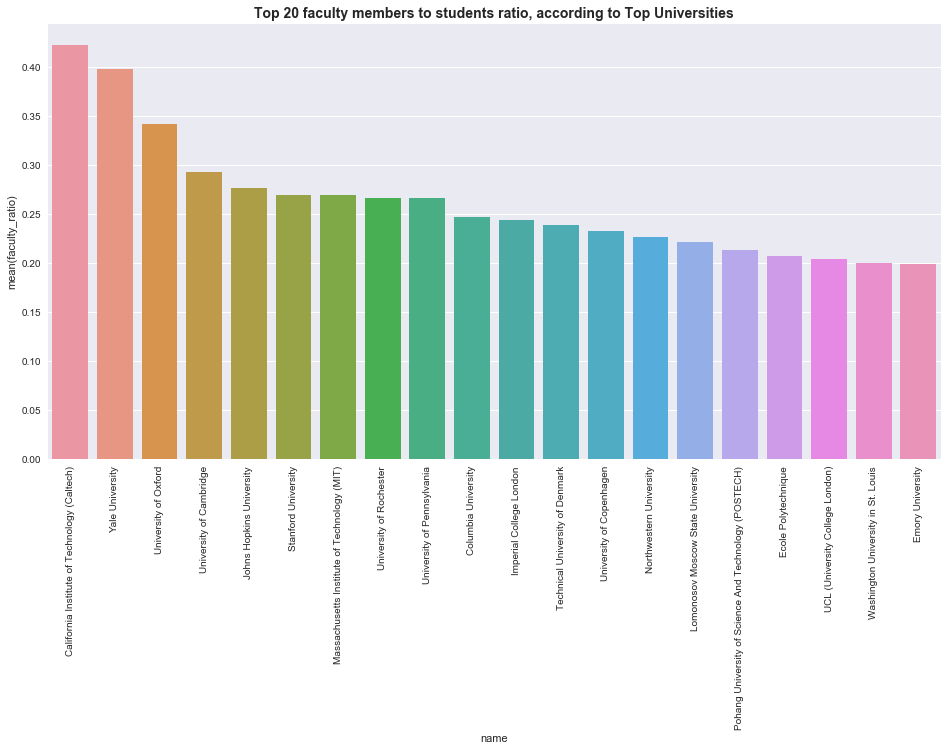

In [248]:
plot_universities_df(top_universities_faculty_ratio_df, 20, "faculty_ratio", "Top 20 faculty members to students ratio, according to Top Universities")

### 1. b) Best universities in term of international students ratio

In [249]:
top_universities_international_ratio_df = get_best_international_ratio_university(top_universities_df)
top_universities_international_ratio_df.head()

,international_ratio,name,rank,students_total,students_international,country,region
34,0.691393,London School of Economics and Political Scien...,35,9760.0,6748.0,United Kingdom,Europe
11,0.570047,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,10343.0,5896.0,Switzerland,Europe
7,0.543567,Imperial College London,8,16090.0,8746.0,United Kingdom,Europe
198,0.502533,Maastricht University,200,16385.0,8234.0,Netherlands,Europe
47,0.478062,Carnegie Mellon University,47,13356.0,6385.0,United States,North America


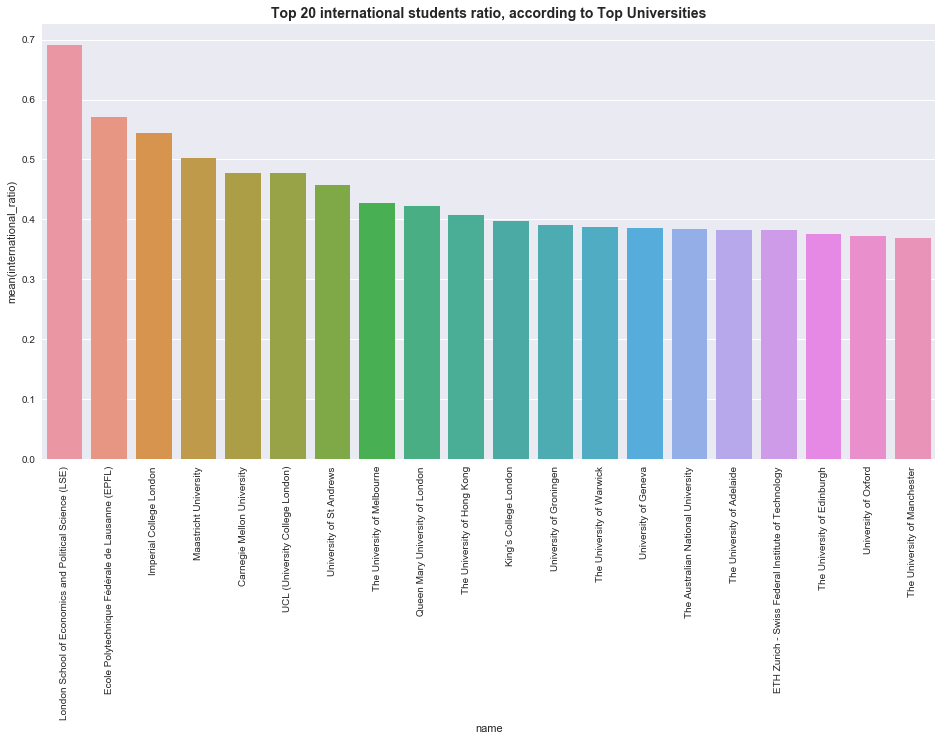

In [250]:
plot_universities_df(top_universities_international_ratio_df, 20, "international_ratio", "Top 20 international students ratio, according to Top Universities")

### 1. c) Best countries

In [251]:
top_universities_countries_df = get_countries_df(top_universities_df)

In [252]:
top_universities_countries_df

,students_total,students_international,faculty_total,faculty_international,faculty_ratio,faculty_ratio_inv,international_ratio
country,,,,,,,
Argentina,122301.0,27109.0,16421.0,3165.0,0.134267,7.447841,0.221658
Australia,301994.0,106359.0,22034.0,11382.0,0.072962,13.705818,0.352189
Austria,63446.0,19667.0,4117.0,1572.0,0.064890,15.410736,0.309980
Belgium,115067.0,17013.0,8046.0,2187.0,0.069924,14.301143,0.147853
Brazil,92283.0,3052.0,7550.0,388.0,0.081814,12.222914,0.033072
Canada,281514.0,73239.0,29317.0,10734.0,0.104140,9.602415,0.260161
Chile,27003.0,991.0,2260.0,198.0,0.083694,11.948230,0.036700
China,235898.0,26833.0,27220.0,6720.0,0.115389,8.666348,0.113748
Denmark,67223.0,9543.0,11916.0,3904.0,0.177261,5.641407,0.141960


### 1. c) a) Best countries in term of faculty members to students ratio

In [253]:
top_universities_countries_faculty_ratio_df = get_best_faculty_ratio_country(top_universities_countries_df)
top_universities_countries_faculty_ratio_df.head()

,faculty_ratio,faculty_ratio_inv,students_total,faculty_total
country,,,,
Russia,0.221910,4.506335,30233.0,6709.0
Denmark,0.177261,5.641407,67223.0,11916.0
Saudi Arabia,0.175828,5.687382,6040.0,1062.0
Singapore,0.161530,6.190809,58466.0,9444.0
Malaysia,0.153893,6.498004,17902.0,2755.0


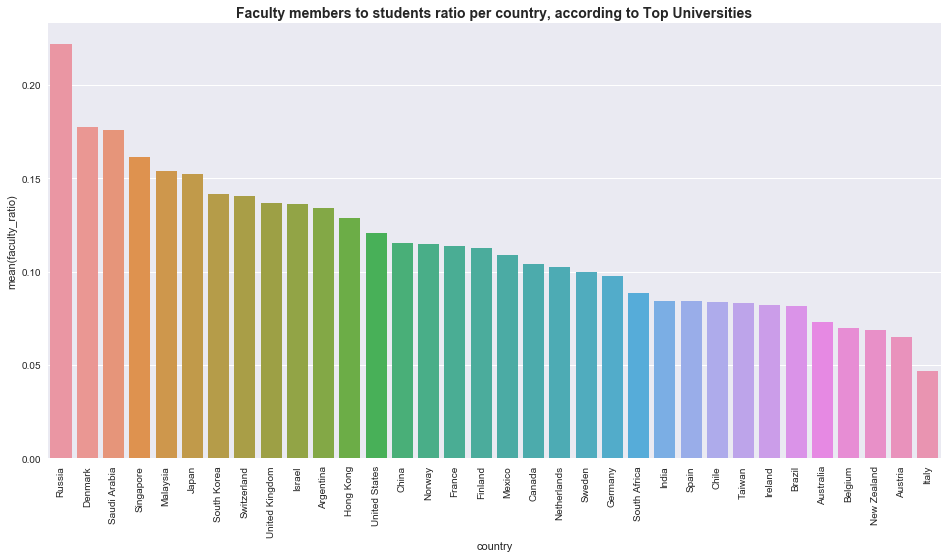

In [254]:
plot_geo_df(top_universities_countries_faculty_ratio_df, "faculty_ratio", "Faculty members to students ratio per country, according to Top Universities")

### 1. c) b) Best countries in term of international students ratio

In [255]:
top_universities_countries_international_ratio_df = get_best_international_ratio_country(top_universities_countries_df)
top_universities_countries_international_ratio_df.head()

,international_ratio,students_total,students_international
country,,,
Australia,0.352189,301994.0,106359.0
United Kingdom,0.341705,583621.0,199426.0
Hong Kong,0.310751,78838.0,24499.0
Austria,0.309980,63446.0,19667.0
Switzerland,0.302396,109112.0,32995.0


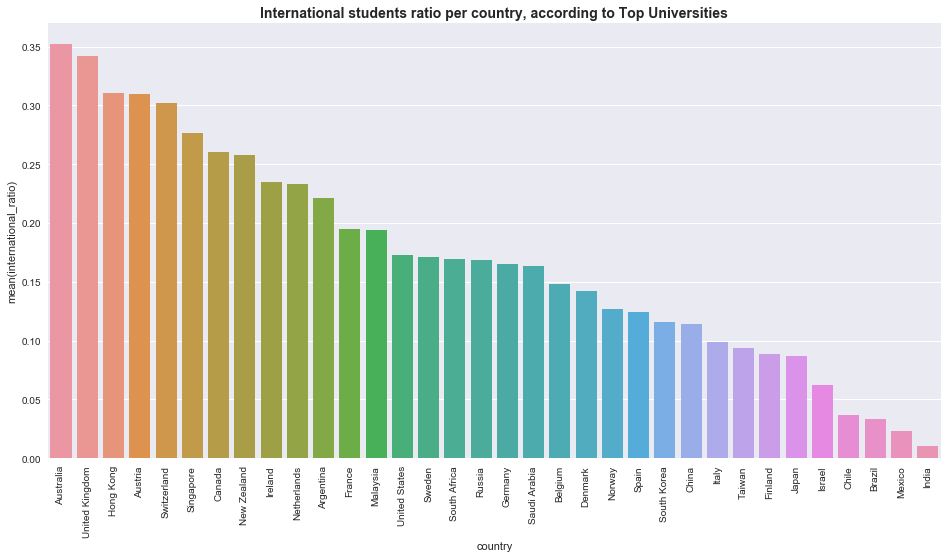

In [256]:
plot_geo_df(top_universities_countries_international_ratio_df, "international_ratio", "International students ratio per country, according to Top Universities")

### 1. d) Best regions

In [257]:
top_universities_regions_df = get_regions_df(top_universities_df)

In [258]:
top_universities_regions_df

,students_total,students_international,faculty_total,faculty_international,faculty_ratio,faculty_ratio_inv,international_ratio
region,,,,,,,
Africa,19593.0,3325.0,1733.0,379.0,0.088450,11.305828,0.169703
Asia,807003.0,110100.0,106734.0,25462.0,0.132260,7.560880,0.136431
Europe,1957251.0,449364.0,218358.0,67598.0,0.111564,8.963496,0.229589
Latin America,396902.0,34737.0,43126.0,5521.0,0.108657,9.203311,0.087520
North America,1546353.0,292116.0,182123.0,43836.0,0.117776,8.490707,0.188906
Oceania,350167.0,118798.0,25347.0,12786.0,0.072385,13.814929,0.339261


### 1. d) a) Best regions in term of faculty members to students ratio

In [259]:
top_universities_regions_faculty_ratio_df = get_best_faculty_ratio_region(top_universities_regions_df)
top_universities_regions_faculty_ratio_df.head()

,faculty_ratio,faculty_ratio_inv,students_total,faculty_total
region,,,,
Asia,0.132260,7.560880,807003.0,106734.0
North America,0.117776,8.490707,1546353.0,182123.0
Europe,0.111564,8.963496,1957251.0,218358.0
Latin America,0.108657,9.203311,396902.0,43126.0
Africa,0.088450,11.305828,19593.0,1733.0


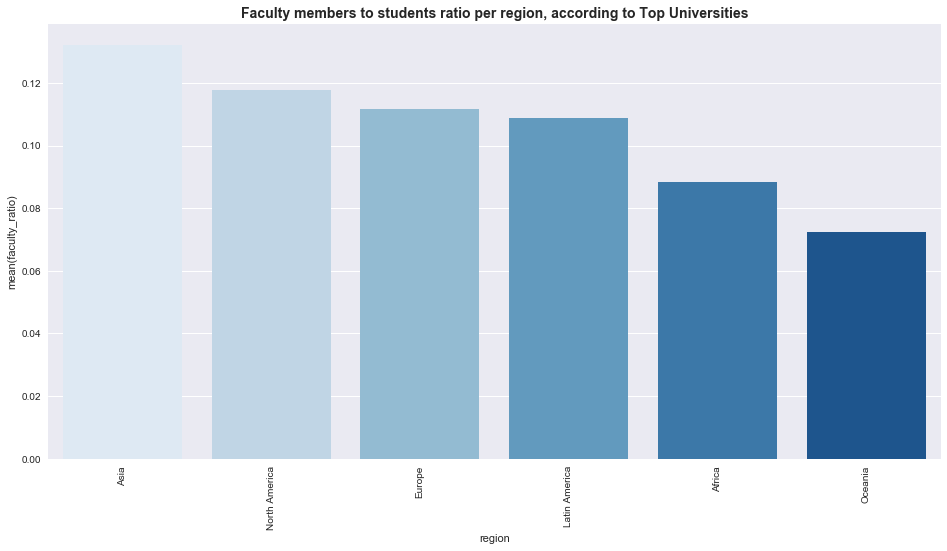

In [260]:
plot_geo_df(top_universities_regions_faculty_ratio_df, "faculty_ratio", "Faculty members to students ratio per region, according to Top Universities")

### 1. d) b) Best regions in term of international students ratio

In [261]:
top_universities_regions_international_ratio_df = get_best_international_ratio_region(top_universities_regions_df)
top_universities_regions_international_ratio_df.head()

,international_ratio,students_total,students_international
region,,,
Oceania,0.339261,350167.0,118798.0
Europe,0.229589,1957251.0,449364.0
North America,0.188906,1546353.0,292116.0
Africa,0.169703,19593.0,3325.0
Asia,0.136431,807003.0,110100.0


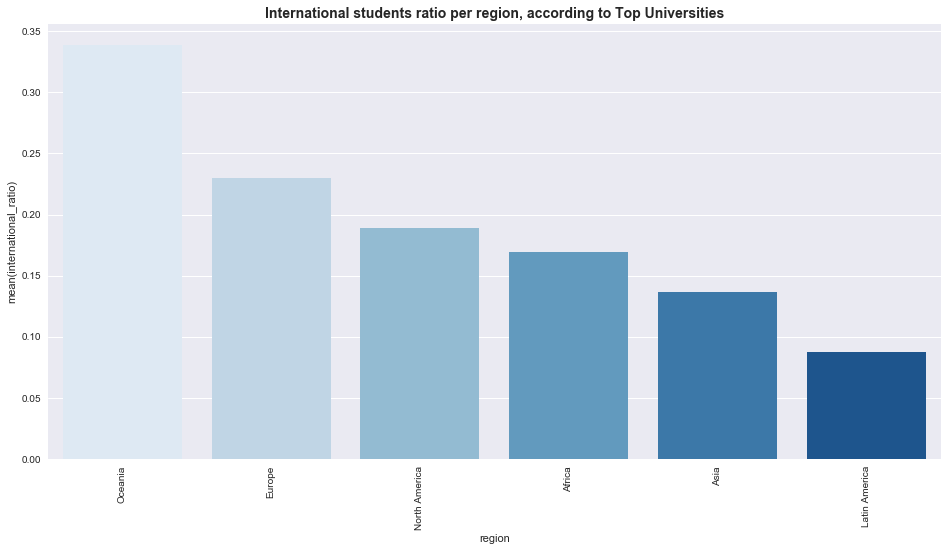

In [262]:
plot_geo_df(top_universities_regions_international_ratio_df, "international_ratio", "International students ratio per region, according to Top Universities")

### Additionnal plots

To have a better overview of the ranking we decided to plot a few representative data

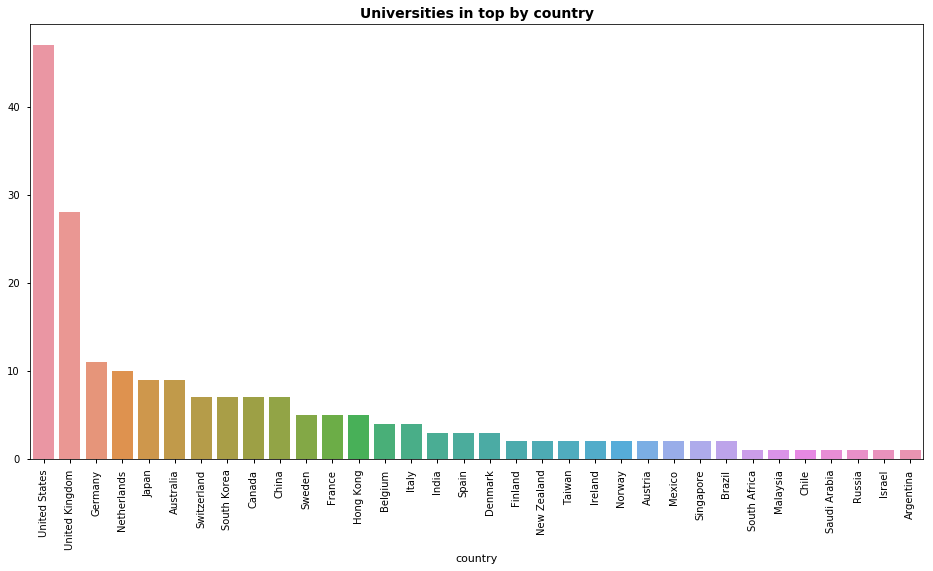

In [26]:
count_country = top_universities_df.groupby('country').count()['rank'].sort_values(ascending=False)
seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(count_country.index, count_country.values,ax=axes)
p.set_xticklabels(count_country.index,rotation=90)
p.set_title('Universities in top by country', fontsize=14, fontweight='bold')

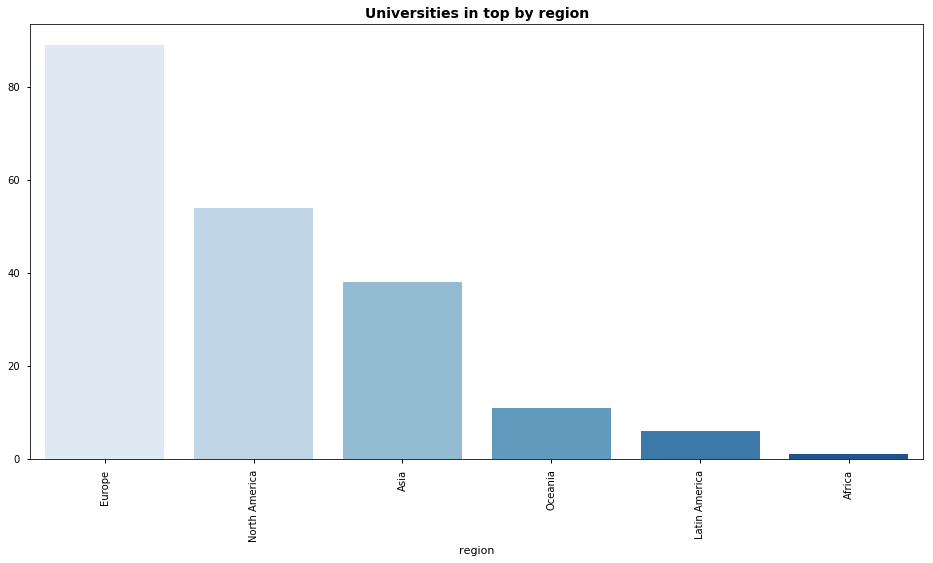

In [27]:
count_region = top_universities_df.groupby('region').count()['rank'].sort_values(ascending=False)
seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(count_region.index, count_region.values,ax=axes)
p.set_xticklabels(count_region.index,rotation=90)
p.set_title('Universities in top by region', fontsize=14, fontweight='bold')

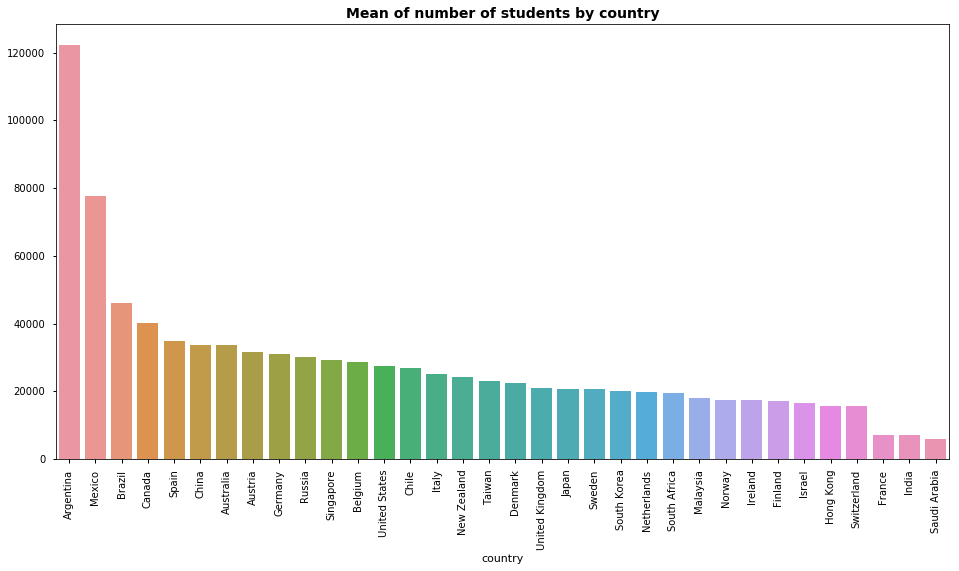

In [28]:
mean_country = top_universities_df.groupby('country').mean()['students_total'].sort_values(ascending=False)
seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(mean_country.index, mean_country.values,ax=axes)
p.set_xticklabels(mean_country.index,rotation=90)
p.set_title('Mean of number of students by country', fontsize=14, fontweight='bold')

We have to be careful with the previous plot, becasue we only take into account universities in the top 200, so all countries does not have the same number of universities. For example, only one university is ranked for Argentina, therefore it is not comparable with other countries such as USA.

## Times ranking

In [75]:
times_ranking_response = cached_get_request("https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json")
times_raw_ranking_data = times_ranking_response.json()['data']

def read_times_entry(raw_entry):
    from math import floor
    
    name = raw_entry["name"]
    rank = read_rank(raw_entry["rank"])
    # TODO: Assert this is always a country
    country = raw_entry["location"]
    # No region found
    region = None
    students_total = read_us_formatted_integer(raw_entry["stats_number_students"])
    
    international_students_ratio = read_percentage(raw_entry["stats_pc_intl_students"])
    students_international = floor(students_total * international_students_ratio)
    
    faculty_to_students_ratio = read_percentage(raw_entry["stats_student_staff_ratio"])
    faculty_total = floor(students_total * faculty_to_students_ratio)
    faculty_international = None
    faculty_ratio = faculty_to_students_ratio*100
    intern_ratio = international_students_ratio*100
    overall_score = float(raw_entry["scores_overall"]) if "scores_overall" in raw_entry else None
    citations_score = float(raw_entry["scores_citations"]) if "scores_citations" in raw_entry else None
    international_score = float(raw_entry["scores_international_outlook"]) if "scores_international_outlook" in raw_entry else None
    
    return make_entry(name, rank, country, region, faculty_total, faculty_international, students_total, students_international,faculty_ratio,intern_ratio,overall_score,citations_score,international_score)
    
#   uniProp['internStudentRatio']=t['stats_pc_intl_students']
#   uniProp['internStudent']=math.floor(float(t['stats_pc_intl_students'].replace("%",""))/100*int(t['stats_number_students'].replace(",","")))#Number looks like this 20,409
#   uniProp['totalFacultyRatio']=t['stats_student_staff_ratio']#TODO define which one we want to use
#   uniProp['totalFaculty']=math.floor(int(t['stats_number_students'].replace(",",""))/float(t['stats_student_staff_ratio']))
#   topBAsObjects.append(uniProp)
    
    result["intern_student"] = None
    
    # TODO define which one we want to use
    result["total_faculty_ratio"] = read_percentage(raw_entry["stats_student_staff_ratio"])
    
    result["total_faculty"] = None
    
    return result

def get_times_data(raw_ranking_data, max_rank):
    """
    Return the list of parsed enries (with details) of the top universities ranking.
    It may perform network requests.
    """
    for raw_entry in raw_ranking_data:
        entry = {}
        
        rank = read_rank(raw_entry["rank"])
        if (rank > max_rank):
            # Assume sorted raw ranks to break (instead of `continue`-ing)
            break

        yield read_times_entry(raw_entry)


def get_times_df(raw_ranking_data, max_rank):
    return pd.DataFrame([*get_times_data(raw_ranking_data, max_rank)])


times_df = get_times_df(times_raw_ranking_data, MAX_RANK)
times_df=times_df[['rank', 'name', 'country', 'region', 'students_total','faculty_total','students_international','faculty_international','faculty_ratio','international_ratio','overall_score','citations_score','international_score']]
times_df.head()

,rank,name,country,region,students_total,faculty_total,students_international,faculty_international,faculty_ratio,international_ratio,overall_score,citations_score,international_score
0,1,University of Oxford,United Kingdom,None,20409,2285,7755,None,11.2,38.0,94.3,99.1,95.0
1,2,University of Cambridge,United Kingdom,None,18389,2004,6436,None,10.9,35.0,93.2,97.5,93.0
2,3,California Institute of Technology,United States,None,2209,143,596,None,6.5,27.0,93.0,99.5,59.7
3,3,Stanford University,United States,None,15845,1188,3485,None,7.5,22.0,93.0,99.9,77.6
4,5,Massachusetts Institute of Technology,United States,None,11177,972,3800,None,8.7,34.0,92.5,100.0,87.6


## Analyse of the dataFrame

### Best universities in term of ratio between faculty members and students

In [30]:
times_df[:10]
#top_universities_df['faculty_student_ratio'] = top_universities_df['students_total']/top_universities_df['faculty_total']
times_universities_df_ratio_fac_students = times_df.sort_values(by='faculty_ratio')[['faculty_ratio','name','rank','students_total','faculty_total','country','region']]
times_universities_df_ratio_fac_students.head()


,faculty_ratio,name,rank,students_total,faculty_total,country,region
105,3.3,Vanderbilt University,105,12011,396,United States,None
109,4.1,University of Copenhagen,109,30395,1246,Denmark,None
12,4.3,Johns Hopkins University,13,15498,666,United States,None
11,4.3,Yale University,12,12155,522,United States,None
153,4.3,University of Rochester,153,9636,414,United States,None


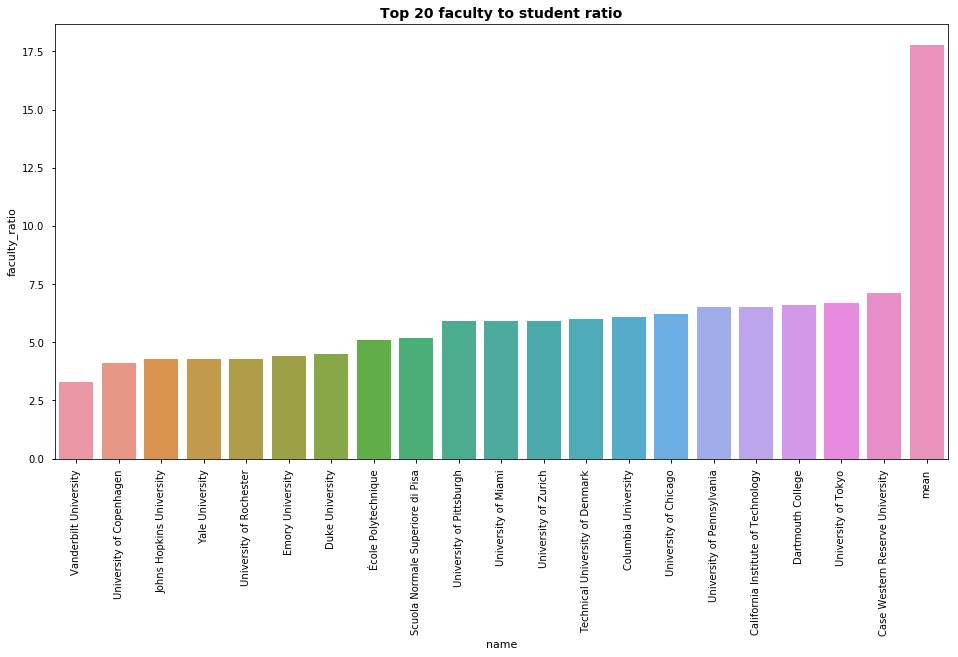

In [31]:
#Ploting results
#We added the mean value to have an order of magnitude
times_10_ratio_fac_mean = times_universities_df_ratio_fac_students[:20][['faculty_ratio','name']]
times_10_ratio_fac_mean.loc[-1] = [times_universities_df_ratio_fac_students['faculty_ratio'].mean(), 'mean'] 

seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(times_10_ratio_fac_mean.name, times_10_ratio_fac_mean['faculty_ratio'],ax=axes)
p.set_xticklabels(times_10_ratio_fac_mean.name,rotation=90)
p.set_title('Top 20 faculty to student ratio', fontsize=14, fontweight='bold')
p

### Best universities in term of ratio of international students

In [32]:
#top_universities_df['international_students_ratio'] = top_universities_df['students_total']/top_universities_df['students_international']
times_universities_df_ratio_intern_students = times_df.sort_values(by='international_ratio')[['international_ratio','name','rank','students_total','students_international','country','region']]
times_universities_df_ratio_intern_students.head()

,international_ratio,name,rank,students_total,students_international,country,region
131,3.0,University of Science and Technology of China,132,16032,480,China,None
161,4.0,"University of California, Santa Cruz",162,17866,714,United States,None
136,4.0,Pohang University of Science and Technology,137,3046,121,South Korea,None
188,6.0,Shanghai Jiao Tong University,188,37288,2237,China,None
177,6.0,Zhejiang University,177,50051,3003,China,None


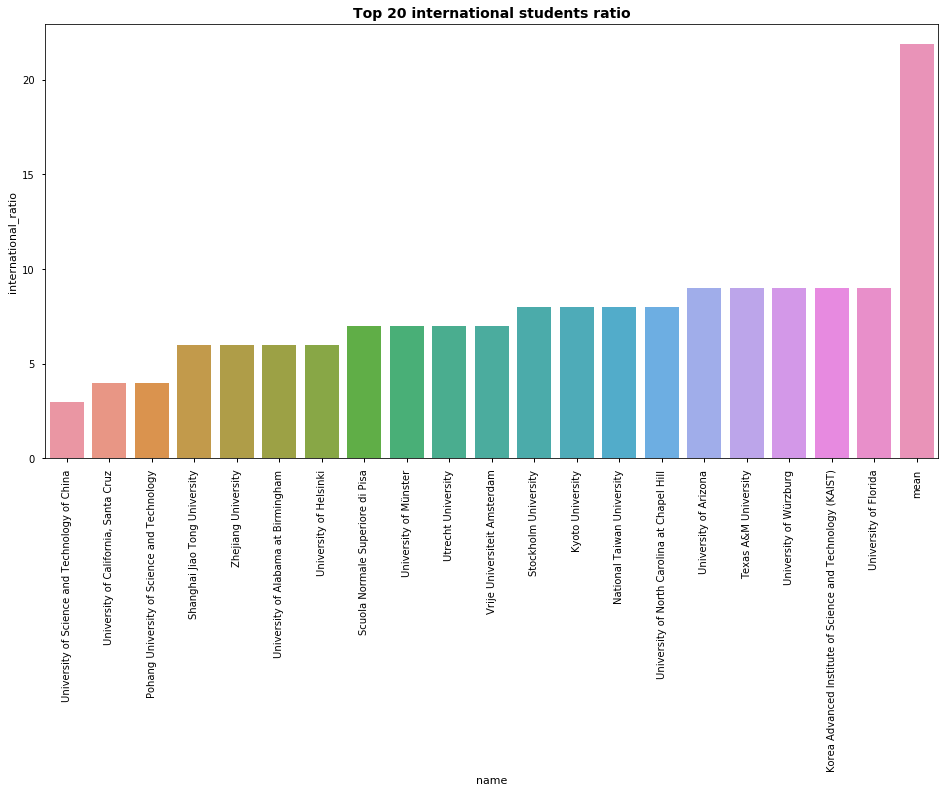

In [33]:
#Ploting results
#We added the mean value to have an order of magnitude
times_10_ratio_intern_mean = times_universities_df_ratio_intern_students[:20][['international_ratio','name']]
times_10_ratio_intern_mean.loc[-1] = [times_universities_df_ratio_intern_students['international_ratio'].mean(), 'mean'] 

seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(times_10_ratio_intern_mean.name, times_10_ratio_intern_mean['international_ratio'],ax=axes)
p.set_xticklabels(times_10_ratio_intern_mean.name,rotation=90)
p.set_title('Top 20 international students ratio', fontsize=14, fontweight='bold')
p

### Best countries in term of ratio between faculty members and students

In [34]:
times_country_ratio_fac_students = times_universities_df_ratio_fac_students.groupby('country').mean()['faculty_ratio'].sort_values()
times_country_ratio_fac_students

country
Russian Federation     7.300000
Japan                  7.700000
Denmark                8.133333
Italy                  8.450000
Taiwan                11.500000
South Africa          11.700000
United States         11.904839
China                 11.942857
South Korea           13.300000
France                13.450000
Switzerland           13.514286
United Kingdom        13.661290
Luxembourg            14.600000
Sweden                15.200000
Singapore             16.650000
Spain                 16.850000
Finland               18.200000
Netherlands           18.330769
Norway                18.600000
New Zealand           18.800000
Hong Kong             19.300000
Canada                19.716667
Austria               20.800000
Ireland               22.800000
Australia             27.462500
Belgium               38.550000
Germany               44.025000
Name: faculty_ratio, dtype: float64

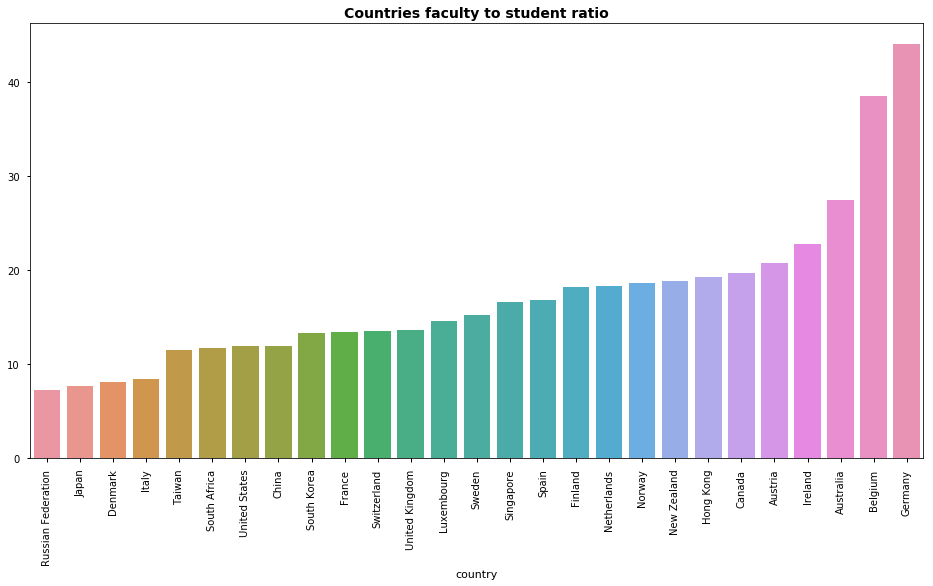

In [35]:
#Ploting results
#top_country_ratio_fac_students.loc['mean'] = top_country_ratio_fac_students.mean()

seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(times_country_ratio_fac_students.index, times_country_ratio_fac_students.values,ax=axes)
p.set_xticklabels(times_country_ratio_fac_students.index,rotation=90)
p.set_title('Countries faculty to student ratio', fontsize=14, fontweight='bold')
p

### Best countries in term of ratio of international students

In [36]:
times_country_ratio_intern_students = times_universities_df_ratio_intern_students.groupby('country').mean()['international_ratio'].sort_values()
times_country_ratio_intern_students

country
Taiwan                 8.000000
China                  8.571429
Japan                  9.000000
South Korea            9.000000
Italy                 10.500000
Finland               13.000000
Spain                 14.000000
Sweden                14.000000
Germany               15.200000
Denmark               16.666667
South Africa          18.000000
United States         18.177419
Norway                19.000000
Netherlands           19.230769
Belgium               19.750000
France                20.833333
Russian Federation    22.000000
Canada                22.500000
Austria               26.000000
Ireland               27.000000
New Zealand           29.000000
Singapore             30.500000
Australia             30.750000
Switzerland           31.428571
Hong Kong             32.800000
United Kingdom        36.548387
Luxembourg            57.000000
Name: international_ratio, dtype: float64

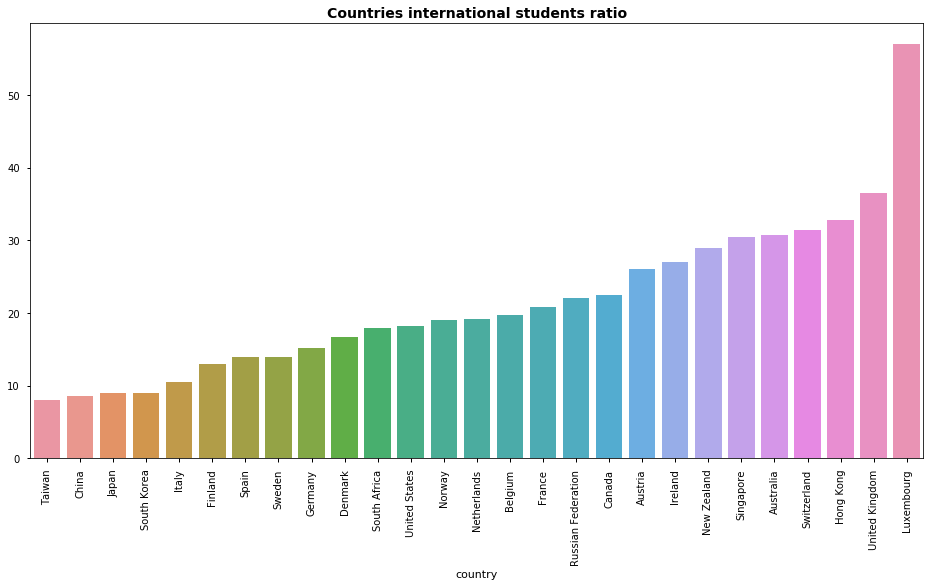

In [37]:
#Ploting results
#top_country_ratio_fac_students.loc['mean'] = top_country_ratio_fac_students.mean()

seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(times_country_ratio_intern_students.index, times_country_ratio_intern_students.values,ax=axes)
p.set_xticklabels(times_country_ratio_intern_students.index,rotation=90)
p.set_title('Countries international students ratio', fontsize=14, fontweight='bold')
p

# TODO : with regions ? 

### Additionnal plots

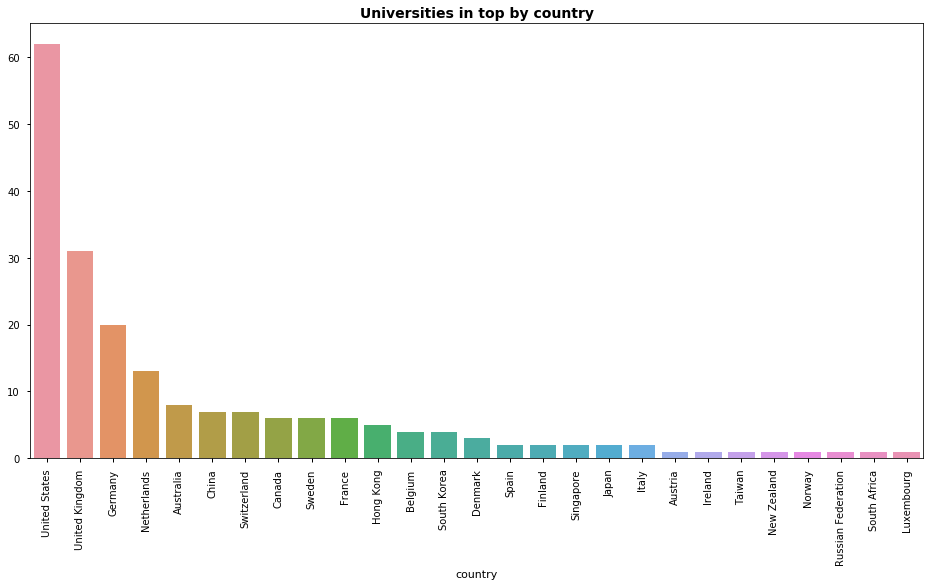

In [38]:
count_country = times_df.groupby('country').count()['rank'].sort_values(ascending=False)
seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(count_country.index, count_country.values,ax=axes)
p.set_xticklabels(count_country.index,rotation=90)
p.set_title('Universities in top by country', fontsize=14, fontweight='bold')

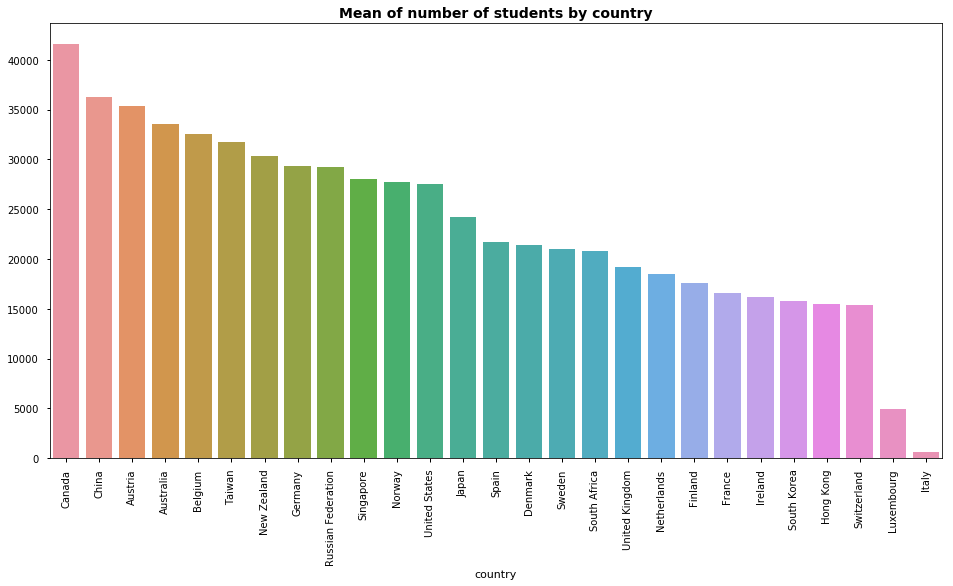

In [39]:
mean_country = times_df.groupby('country').mean()['students_total'].sort_values(ascending=False)
seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(mean_country.index, mean_country.values,ax=axes)
p.set_xticklabels(mean_country.index,rotation=90)
p.set_title('Mean of number of students by country', fontsize=14, fontweight='bold')

## Question 3

In [41]:
#TODO : can't you make without unidecode ??? 

In [87]:
import string, unidecode
from math import sqrt

def text_synonyms(text):
    synonyms = {
        'universiti':'university', 
        'universite':'university', 
        'universitat':'university', 
        'universitaet':'university', 
        'universidad':'university', 
        'universidade':'university', 
        'universiteit':'university',
        'king\'s':'kings'
    }
    return [word if not(word in synonyms) else synonyms[word] for word in text]

def text_bigrams(text):
    """
    Return the bigrams of the list of tokens
    """
    bigrams  = []
    for index, word in enumerate(text):
        if index + 1 < len(text):
            bigrams += [word + " " + text[index + 1]]
    return bigrams

def text_preprocessing(df, columns="name", suffix="_preprocessed", stopwords=set(["le", "la", "the", "of", "de", "and", "at", "et"])):
    """
    For all selected textual columns of dataframe, 
    append a new preprocessed column which consist of a set of tokens and bigrams
    extracted from text, without any punctuations/accents/uppercases/stopwords.
    """
    data = df[[columns]]
    data = data.applymap(lambda text: unidecode.unidecode(text.lower().translate(str.maketrans('-–', '  ')).translate(str.maketrans('', '', string.punctuation))))
    data = data.applymap(lambda text: [token for token in text.split() if token not in stopwords])
    data = data.applymap(lambda text: text_synonyms(text))
    data = data.applymap(lambda text: set(text + text_bigrams(text)))
    data = data.add_suffix(suffix)
    return df.join(data)

def dataframe_crossjoin(A, B, suffixes=('_A', '_B')):
    """
    Return the cartesian product between the two DataFrames
    """
    A['_tmpkey'] = 1
    B['_tmpkey'] = 1

    AB = pd.merge(A, B, on='_tmpkey', suffixes=suffixes).drop('_tmpkey', axis=1)
    AB.index = pd.MultiIndex.from_product((A.index, B.index))

    A.drop('_tmpkey', axis=1, inplace=True)
    B.drop('_tmpkey', axis=1, inplace=True)

    return AB

def set_distance(A, B):
    """
    Return the distance between two sets, card(A & B) / card(A | B)
    """
    inter = A.intersection(B)
    union = A.union(B)
    return (len(inter) / len(union))

def merge_data(A , B, left_on="name", right_on="name", suffixes=('_A', '_B'), similarity=0.50):
    """
    Merge the data according to the similarity between the two sets of words
    """
    #Exact macth
    exact_matches = A.merge(B, left_on=left_on, right_on=right_on, how="inner", suffixes=suffixes)
    
    #Select doesn't match
    A_no_matches  = A[~A[left_on ].isin(exact_matches[left_on ])]
    B_no_matches  = B[~B[right_on].isin(exact_matches[right_on])]
    
    A = text_preprocessing(A_no_matches, left_on )
    B = text_preprocessing(B_no_matches, right_on)
    
    #Select amongst all possibles pairs, the best one, with a similarity at least higher than the threshold
    cross = dataframe_crossjoin(A, B, suffixes)
    
    selected_cross = cross[[left_on  + "_preprocessed" + suffixes[0], right_on + "_preprocessed" + suffixes[1]]]
    selected_cross = pd.DataFrame(selected_cross.apply(lambda x: set_distance(x[0], x[1]), axis=1))
    selected_cross = selected_cross.loc[selected_cross.groupby(level=0).idxmax()[0]]
    selected_cross = selected_cross.loc[selected_cross.groupby(level=1).idxmax()[0]]
    selected_cross = (selected_cross >= similarity)[0]
    selected_cross = selected_cross[selected_cross].index.tolist()
    
    #We select the first name as the reference
    fuzzy_matches = cross.loc[selected_cross][[left_on + suffixes[0]] + exact_matches.columns[1:].tolist()].reindex()
    fuzzy_matches.columns = exact_matches.columns
    
    A_no_matches = A_no_matches[~A_no_matches.index.isin([x[0] for x in fuzzy_matches.index.values])]
    B_no_matches = B_no_matches[~B_no_matches.index.isin([x[1] for x in fuzzy_matches.index.values])]
    
    matches = exact_matches.append(fuzzy_matches)
    matches.index = [i for i in range(0, matches.shape[0])]
    
    #return cross.loc[selected_cross], A_no_matches, B_no_matches
    return matches, A_no_matches, B_no_matches
    
m, a, b = merge_data(times_df[["name", "rank"]], top_universities_df[["name", "rank"]], suffixes=('_times','_top_universities'))
m

,name,rank_times,overall_score_times,citations_score_times,international_score_times,rank_top_universities,overall_score_top_universities,citations_score_top_universities,international_score_top_universities
0,University of Oxford,1,94.3,99.1,95.0,6,95.3,76.3,98.55
1,University of Cambridge,2,93.2,97.5,93.0,5,95.6,78.3,97.55
2,Stanford University,3,93.0,99.9,77.6,2,98.7,99.4,86.15
3,Harvard University,6,91.8,99.7,79.7,3,98.4,99.9,85.85
4,Princeton University,7,91.1,99.6,78.7,13,91.0,100.0,69.10
5,Imperial College London,8,89.2,96.7,96.6,8,93.7,68.7,100.00
6,University of Chicago,9,88.6,99.4,69.6,9,93.5,85.9,75.85
7,University of Pennsylvania,10,87.7,98.5,61.3,19,88.7,67.4,65.80
8,Yale University,12,87.6,98.4,64.6,16,90.4,63.2,76.20
9,Johns Hopkins University,13,86.5,98.4,70.6,17,89.8,83.9,84.60


In [ ]:
m, a, b = merge_data(times_df[["name", "rank","overall_score","citations_score","international_score"]], top_universities_df[["name", "rank","overall_score","citations_score","international_score"]], suffixes=('_times','_top_universities'))

# Part 5 


First idea : 
Mean of rank numbers.
TODO : Show results and analyse them. Maybe too much equalities or wierd results ?


In [68]:
merging_rank = m.copy()
merging_rank['mean_of_rank'] = (merging_rank['rank_times']+merging_rank['rank_top_universities'])/2
merging_rank.sort_values(by="mean_of_rank",inplace=True)
merging_rank.reset_index(drop=True,inplace=True)
merging_rank[["name","mean_of_rank","rank_times","rank_top_universities"]]

,name,mean_of_rank,rank_times,rank_top_universities
0,Stanford University,2.5,3,2
1,Massachusetts Institute of Technology,3.0,5,1
2,California Institute of Technology,3.5,3,4
3,University of Oxford,3.5,1,6
4,University of Cambridge,3.5,2,5
5,Harvard University,4.5,6,3
6,Imperial College London,8.0,8,8
7,University of Chicago,9.0,9,9
8,Princeton University,10.0,7,13
9,ETH Zurich – Swiss Federal Institute of Techno...,10.0,10,10


Second idea : 
Use more precise scores : 
For example we have following scores : 
**Times** 
* overall score
* teaching
* research
* citations
* industry income
* international outlook

**top**
* academic reputation
* citations per faculty
* employer reputation
* faculty student
* international faculty
* international student

We can notice similar categories : 
The most important is overall score. 
We can take just the mean of both of them and make a new ranking.


In [86]:
merging_score = m.copy()
merging_score['mean_of_score'] = (merging_score['overall_score_times']+merging_score['overall_score_top_universities'])/2
merging_score.sort_values(by="mean_of_score",inplace=True,ascending=False)
merging_score.reset_index(drop=True,inplace=True)
merging_score[["name","mean_of_score","overall_score_times","overall_score_top_universities"]]

,name,mean_of_score,overall_score_times,overall_score_top_universities
0,Massachusetts Institute of Technology,96.25,92.5,100.0
1,Stanford University,95.85,93.0,98.7
2,California Institute of Technology,95.35,93.0,97.7
3,Harvard University,95.10,91.8,98.4
4,University of Oxford,94.80,94.3,95.3
5,University of Cambridge,94.40,93.2,95.6
6,Imperial College London,91.45,89.2,93.7
7,Princeton University,91.05,91.1,91.0
8,University of Chicago,91.05,88.6,93.5
9,ETH Zurich – Swiss Federal Institute of Techno...,90.50,87.7,93.3


Scores that are also presents : 
* citations 
    * times : 30% 
    * top : 20%
    * times : We examine research influence by capturing the number of times a university’s published work is cited by scholars globally.
    * Top : To calculate it, we the total number of citations received by all papers produced by an institution across a five-year period by the number of faculty members at that institution.
    * Both are normalized
* international outlook and mean of (international faculty and international student)
    * times : 7,5%
    * Top 2* 5% 
    * Times : calculated like this :
        * International-to-domestic-student ratio: 2.5%
        * International-to-domestic-staff ratio: 2.5%
        * International collaboration: 2.5%
Maybe we can use mean of overall score and take more into account citations and international outlook at it is present in both ranking 
We will use the following formula : New score = Mean(0.6\*overall_score+0.3\*citations_score+0.1\*international_score)
How did we end up with this formula ? 
We think that the overall score remains the most important factor, but to compare both scores we will just add weigth to common criteria.
We don't want to add too much importance to the criteria, so we keep overall score for 60% of the new score. Then we keep the ratio used by both times and top universities between citations and international_score

In [88]:
merging_score = m.copy()
merging_score['new_score_times'] = 0.6 * merging_score['overall_score_times'] + 0.3*merging_score['citations_score_times']+0.1*merging_score["international_score_times"]
merging_score['new_score_top_universities'] = 0.6 * merging_score['overall_score_top_universities'] + 0.3*merging_score['citations_score_top_universities']+0.1*merging_score["international_score_top_universities"]
merging_score['mean_of_new_score'] = (merging_score['new_score_times']+merging_score['new_score_top_universities'])/2
merging_score.sort_values(by="mean_of_new_score",inplace=True,ascending=False)
merging_score.reset_index(drop=True,inplace=True)
merging_score[["name","mean_of_new_score","new_score_times","new_score_top_universities","overall_score_times","overall_score_top_universities"]]

,name,mean_of_new_score,new_score_times,new_score_top_universities,overall_score_times,overall_score_top_universities
0,Massachusetts Institute of Technology,97.0175,94.26,99.775,92.5,100.0
1,Stanford University,95.5925,93.53,97.655,93.0,98.7
2,Harvard University,95.2775,92.96,97.595,91.8,98.4
3,California Institute of Technology,94.6850,91.62,97.750,93.0,97.7
4,ETH Zurich – Swiss Federal Institute of Techno...,93.1250,90.72,95.530,87.7,93.3
5,University of Oxford,92.8675,95.81,89.925,94.3,95.3
6,University of Cambridge,92.5375,94.47,90.605,93.2,95.6
7,Princeton University,91.9600,92.41,91.510,91.1,91.0
8,University of Chicago,89.6975,89.94,89.455,88.6,93.5
9,Imperial College London,89.5100,92.19,86.830,89.2,93.7
